### Imports

In [1]:
from pathlib import Path
import pandas as pd
import numpy as np
import json
import random
import matplotlib.pyplot as plt
import seaborn as sns

### Constants

In [2]:
basedir = Path("/Users/tusharsingh/Work/Project/DL-cdr3-tumor")

tumor_file  = basedir / "raw_data" / "TRB_cancer_lung.csv"
normal_file = basedir / "raw_data" / "TRB_normal_lung.csv"
plot_dir    = basedir / "plots"
output_path = basedir / "processed" / "cdr3_tumor_normal.jsonl"

MIN_CDR3S      = 20
TARGET_CDR3S   = 40
MAX_SEQ_LEN    = 22
PADSEQ         = "PADSEQ"

AMINO_ACIDS = list("ACDEFGHIKLMNPQRSTVWY")
PAD_TOKEN = "<PAD>"
UNK_TOKEN = "<UNK>"

VOCAB = {aa: idx + 2 for idx, aa in enumerate(AMINO_ACIDS)}
VOCAB[PAD_TOKEN] = 0
VOCAB[UNK_TOKEN] = 1

In [3]:
plot_dir.mkdir(parents=True, exist_ok=True)
(basedir / "processed").mkdir(exist_ok=True)

### Load & prepare data

In [4]:
# Read CSVs
df_tumor = pd.read_csv(tumor_file)
df_normal = pd.read_csv(normal_file)

# Add label
df_tumor['label'] = 'tumor'
df_normal['label'] = 'normal'

# Combine into one DataFrame
df_all = pd.concat([df_tumor, df_normal], ignore_index=True)
print("Tumor rows:", len(df_tumor))
print("Normal rows:", len(df_normal))
print("Total rows:", len(df_all))


Tumor rows: 18053
Normal rows: 14964
Total rows: 33017


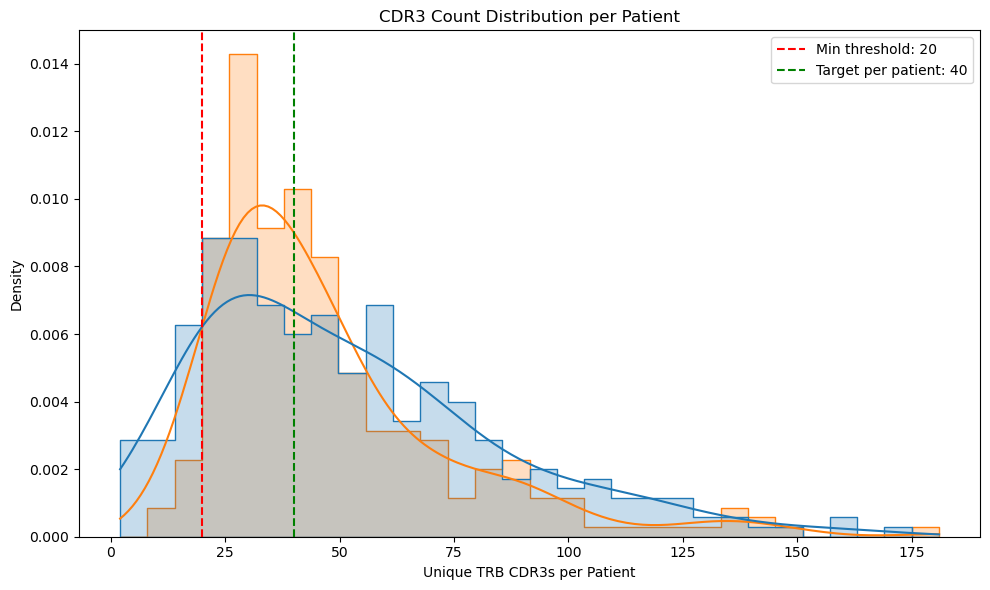

In [5]:
tumor_counts = df_tumor.groupby("Sample ID")["CDR3"].nunique()
normal_counts = df_normal.groupby("Sample ID")["CDR3"].nunique()

def plot_cdr3_distribution(tumor_counts, normal_counts, output_file):
    data = pd.DataFrame({
        "CDR3 Count": list(tumor_counts) + list(normal_counts),
        "Tissue": ["Tumor"] * len(tumor_counts) + ["Normal"] * len(normal_counts)
    })

    plt.figure(figsize=(10, 6))
    sns.histplot(data=data, x="CDR3 Count", hue="Tissue", bins=30, kde=True, element="step", stat="density")
    plt.axvline(MIN_CDR3S, color='red', linestyle='--', label=f"Min threshold: {MIN_CDR3S}")
    plt.axvline(TARGET_CDR3S, color='green', linestyle='--', label=f"Target per patient: {TARGET_CDR3S}")
    plt.title("CDR3 Count Distribution per Patient")
    plt.xlabel("Unique TRB CDR3s per Patient")
    plt.ylabel("Density")
    plt.legend()
    plt.tight_layout()
    plt.savefig(plot_dir / output_file)
    plt.show()

plot_cdr3_distribution(tumor_counts, normal_counts, "cdr3_patient_counts_tumor_normal.png")


### Tokenization

In [6]:
def tokenize_sequence(seq, max_len=MAX_SEQ_LEN):
    tokens = [VOCAB.get(aa, VOCAB[UNK_TOKEN]) for aa in seq]
    if len(tokens) < max_len:
        tokens += [VOCAB[PAD_TOKEN]] * (max_len - len(tokens))
    else:
        tokens = tokens[:max_len]
    return tokens


### Patient lvl Normalization

In [7]:
def process_group(df, label):
    patient_samples = []
    grouped = df.groupby("Sample ID")

    for patient_id, group in grouped:
        unique_cdr3s = list(set(group["CDR3"].dropna()))
        if len(unique_cdr3s) < MIN_CDR3S:
            continue

        if len(unique_cdr3s) > TARGET_CDR3S:
            selected = random.sample(unique_cdr3s, TARGET_CDR3S)
        else:
            selected = unique_cdr3s + [PADSEQ] * (TARGET_CDR3S - len(unique_cdr3s))

        tokenized = [tokenize_sequence(seq) for seq in selected]

        patient_samples.append({
            "Sample ID": patient_id,
            "cdr3s": tokenized,
            "label": label
        })

    return patient_samples

tumor_processed  = process_group(df_tumor, label="tumor")
normal_processed = process_group(df_normal, label="normal")

# Balance
n = min(len(tumor_processed), len(normal_processed))
combined_samples = tumor_processed[:n] + normal_processed[:n]
random.shuffle(combined_samples)

print(f"Final: {len(combined_samples)} patients (tumor={n}, normal={n})")


Final: 532 patients (tumor=266, normal=266)


#### Saving data

In [8]:
with open(output_path, 'w') as f:
    for sample in combined_samples:
        f.write(json.dumps(sample) + "\n")

print(f"Saved to {output_path}")


Saved to /Users/tusharsingh/Work/Project/DL-cdr3-tumor/processed/cdr3_tumor_normal.jsonl
